In [54]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from tqdm.notebook import tqdm # Waiting/loading bar for loops

import seaborn as sns

In [366]:
# Own implementations
%load_ext autoreload
%autoreload 2
from data_generation import *
from linear_model import *
from transformation import *
from pipeline import Pipeline
from metric import *
from model_selection import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [343]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=True
save_dir = "../../../tex/01_regression_resampling/img/"

# Some shorthands for figure labels/legends
MSE = r"\hat\mathcal{E}"
var = r"\widehat{\mathrm{Var}}[\hat f]"
Bias = r"\widehat{\mathrm{Bias}}[\hat f]"
noise = r"\sigma^2"

## Bias-Variance Tradeoff and Model Selection

In [ ]:
# Construction of our vanilla data set. Seeds are fixexd for reproducability
# (see defintion of random_x_y_franke() and its default arguments)
N = 600
sigma = .1
x,y,z = random_x_y_franke(N,sigma=sigma)

### Overfitting - Underfitting from Train/Test MSE

Here we demonstrate the failure of the *train* MSE to be a good estimtor for the expected prediction error (under squared loss), as well as the overfitting/underfitting regime captured by the *test* MSE.

Code snippets below produce Fig. TBA of the report

In [ ]:
complexity = np.arange(1,14)
mse_train = []
mse_test = []

# By using our own pipeline, we absorb the standardization step 
# (learned from the trainings data only!) 
# into the fit() and predict() step of the Predictor (here OLS).
ols = Pipeline([Standardization(), OrdinaryLeastSquare()])

for p in complexity:
    X = generate_design_matrix(x, y, p)
    X_train, X_test, y_train, y_test = train_test_split(X,z,test_size=0.25)
       
    ols.fit(X_train,y_train)
    
    mse_test.append(mse(y_test, ols.predict(X_test)))
    mse_train.append(mse(y_train, ols.predict(X_train)))

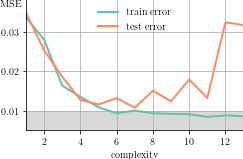

In [299]:
sns.set_palette("Set2",8)
size = (3.9, 0.618 * 3.9) if save else (10,6)

fig, ax = plt.subplots(figsize=size)
ax.plot(complexity, mse_train, label="train error")
ax.plot(complexity, mse_test, label="test error")
ax.fill_between(complexity, sigma**2, 0.005, alpha=.3, linewidth=0, color="gray")

ax.set_xlabel("complexity") 
ax.set_ylabel("MSE", rotation=0)
ax.yaxis.set_label_coords(-0.07,0.93)
ax.legend(*ax.get_legend_handles_labels(), loc=0)
ax.set_xlim([complexity[0],complexity[-1]])
ax.set_ylim([0.005,1.1*max(np.max(mse_test), np.max(mse_train))])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid(True)

if save:
    fig.savefig(save_dir + "train_test_error.pdf",bbox_inches="tight",pad_inches = 0)
else:
    plt.show()

### Bootstrap Analysis

We proceed to analyse the bias-variance decomposition under OLS given our Franke data both as a function of data set size $N$ and model complexity $p$.

Code snippets below produce Fig. TBA of the report

In [24]:
# Model parameters
degrees = np.arange(1,11)

In [319]:
# Data parameters
Ns = np.union1d(np.logspace(2,4,100).astype(int), np.arange(100,1000,100))

# Resampling
B = 50

# Predictor Pipeline
ols = Pipeline([Standardization(), OrdinaryLeastSquare()])

# Error Components
prediction_error_bs = np.empty((degrees.shape[0], Ns.shape[0]))
bias = np.empty((degrees.shape[0], Ns.shape[0]))
variance = np.empty((degrees.shape[0], Ns.shape[0]))

for j,N in enumerate(tqdm(Ns)):
    x,y,z = random_x_y_franke(N)
    for k,p in enumerate(degrees):
        X = generate_design_matrix(x, y, p)
        # We disable shuffling as we want to fit different models to the same trainings data. 
        # Note that random resampling (draw + replace) still takes place
        prediction_error_bs[k,j], bias[k,j], variance[k,j] = \
                predicition_error_bootstrap(squared_error, ols, X, z, B=B, decomp=True, shuffle=False)

  0%|          | 0/107 [00:00<?, ?it/s]

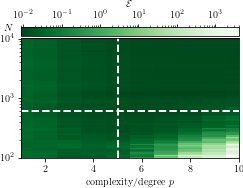

In [378]:
# Parameter sweep plot

kwargs = {"lw":2, 
          "cmap":sns.color_palette("Greens_r", as_cmap=True),
          "shading":"nearest",
          "norm":colors.LogNorm(vmin=prediction_error_bs[1:,:].min(), 
                                vmax=prediction_error_bs[1:,:].max()),
          "antialiased":False,
          "edgecolor": "face",
          "rasterized":True,
          "linewidth": 0
         }

# Note location for the cross sections are chosen arbitrarily
N_cross_section = 600
p_cross_section = 5
idx = np.where(degrees == p_cross_section)[0][0]
idy = np.abs(Ns - N_cross_section).argmin()

size = (3.9, 0.618 * 3.9) if save else (10,6)
fig,ax = plt.subplots(figsize=size)
ax.set_yscale("log")
im = ax.pcolormesh(degrees, Ns, prediction_error_bs.T, **kwargs)
im.set_edgecolor('face')
ax.set_xlabel(r'complexity/degree $p$')
ax.set_ylabel(r'$N$', rotation=0)
ax.yaxis.set_label_coords(-0.06,1.04)

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.set_xlabel(rf"${MSE}$")
cax.xaxis.set_label_position('top') 
ax.axhline(y=N_cross_section, c="w", ls="dashed")
ax.axvline(x=p_cross_section, c="w", ls="dashed")
ax.set_xlim([1,degrees[-1]])

if save:
    fig.savefig(save_dir + "ols_complexity_N_MSE.pdf", dpi=600)
else:
    plt.show()

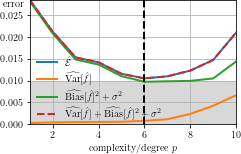

In [331]:
# Plot for horizontal cross section

size = (3.7, 0.618 * 3.7) if save else (10,6)
fig,ax = plt.subplots(figsize=size)


sns.set_palette("tab10")

ax.plot(degrees, prediction_error_bs[:,idy], label=rf"${MSE}$")
var_line = ax.plot(degrees, variance[:,idy], label=rf"${var}$")
bias_line = ax.plot(degrees, bias[:,idy], label=rf"${Bias}^2 + {noise}$")
ax.plot(degrees, variance[:,idy] + bias[:,idy], 
        label=rf"${var} + {Bias}^2 + {noise}$", ls="dashed")

ax.set(xlabel="complexity/degree $p$")
ax.set_ylabel(r"error", rotation=0)
ax.yaxis.set_label_coords(-0.08,0.93)

ax.fill_between(complexity, sigma**2, 0, alpha=.3, linewidth=0, color="gray")
ax.axvline(degrees[np.argmin(prediction_error_bs[:,idy])], ls="dashed",c="k")
ax.set_xlim([degrees[0],degrees[-1]])
ax.set_ylim([0,np.max(prediction_error_bs[:,idy])])
ax.legend(*ax.get_legend_handles_labels(),bbox_to_anchor=[-0.01, -0.04], loc="lower left")
ax.grid(True)

if save:
    fig.savefig(save_dir + "ols_decomp_complexity.pdf")
else:
    plt.show()

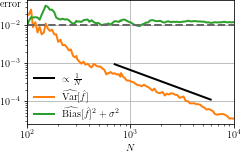

In [330]:
# Variance Scaling Plot

size = (3.7, 0.618 * 3.7) if save else (10,6)
fig, ax = plt.subplots(figsize=size)
ax.set_xscale("log")
ax.set_yscale("log")

N_power = Ns[np.logical_and(Ns>700,Ns<6000)]
ax.plot(N_power, 1.0/(1.5*N_power), c="k", label=r"$\propto \frac{1}{N}$")
ax.plot(Ns, variance[idx,:], label=rf"${var}$", c=var_line[0].get_color())
ax.plot(Ns, bias[idx,:], label=rf"${Bias}^2 + {noise}$", c=bias_line[0].get_color())

ax.set(xlabel=r"$N$") 
ax.set_ylabel(r"error", rotation=0)
ax.yaxis.set_label_coords(-0.08,0.93)
ax.axhline(sigma**2, ls="dashed",color="dimgray")
ax.legend(*ax.get_legend_handles_labels(),bbox_to_anchor=[-0.01, -0.04], loc="lower left")

if save:
    fig.savefig(save_dir + "ols_decomp_N.pdf")
else:
    plt.show()

### Cross-Validation

We double-check our results for bootstrap by an independent cross-validation analysis. 

Code snippets below generate Fig. TBA of the report

In [340]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


# Data generation
N = 600
x,y,z = random_x_y_franke(N)

# Cross validation parameters
Nfolds = np.arange(5,10)

# Predictor Pipeline
ols = Pipeline([Standardization(), OrdinaryLeastSquare()])

prediction_error_kfold =  np.empty((Nfolds.shape[0], degrees.shape[0]))
prediction_error_kfold_std =  np.empty((Nfolds.shape[0], degrees.shape[0]))

for k,folds in enumerate(tqdm(Nfolds)):
    for i,p in enumerate(degrees):
        X = generate_design_matrix(x, y, p)
        prediction_error_kfold[k,i], prediction_error_kfold_std[k,i] = \
            prediction_error_CV(squared_error, ols, X, z, nfolds=folds)
   

  0%|          | 0/5 [00:00<?, ?it/s]

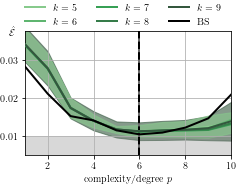

In [376]:
size = (3.7, 0.618 * 3.7) if save else (10,6)

fig, ax = plt.subplots(figsize=size)
sns.set_palette("Greens_d", 5)

lines = []
for k in range(Nfolds.shape[0]):
    lines.append(ax.plot(degrees, prediction_error_kfold[k,:], label=rf"$k={Nfolds[k]}$", zorder=10))

ax.plot(degrees, prediction_error_bs[:,idy],  c="k", label=r"BS", zorder=11)

ax.fill_between(degrees, 
                prediction_error_kfold[-1,:]-prediction_error_kfold_std[-1,:], 
                prediction_error_kfold[-1,:]+prediction_error_kfold_std[-1,:], 
                alpha = 0.6, color=lines[-1][0].get_color())
ax.fill_between(degrees, 
                prediction_error_kfold[0,:]-prediction_error_kfold_std[0,:], 
                prediction_error_kfold[0,:]+prediction_error_kfold_std[0,:], 
                alpha = 0.6, color=lines[0][0].get_color())

ax.axvline(x=degrees[np.argmin(prediction_error_kfold[0,:])], c="dimgrey")
ax.axvline(x=degrees[np.argmin(prediction_error_bs[:,idy])], ls="dashed",c="k")

ax.fill_between(complexity, sigma**2, 0, alpha=.3, linewidth=0, color="gray")
ax.set(xlabel=r"complexity/degree $p$")
ax.set_ylabel(rf"${MSE}$", rotation=0)
ax.yaxis.set_label_coords(-0.06,0.94)

ax.set_xlim([degrees[0],degrees[-1]])
ax.set_ylim([0,np.max(prediction_error_kfold)])
ax.legend(*ax.get_legend_handles_labels(),bbox_to_anchor=[-0.04, .96], loc="lower left", ncol=3)
ax.set_ylim([0.005,1.1*np.max(prediction_error_kfold)])

if save:
    fig.savefig(save_dir + "ols_cross_val.pdf")
else:
    plt.show()

### Model Selection & Model Assessment

By minimizing the MSE curve for fixed $N=600$, we find the optimal model complexity for OLS.

In [379]:
N_cross_section = 600
idy = np.abs(Ns - N_cross_section).argmin()
idx = prediction_error_bs[:,idy].argmin()
idy_cv = prediction_error_kfold[0,:].argmin()

ols_mse_min_bs = prediction_error_bs[idx,idy]
ols_mse_min_cv = prediction_error_kfold[0,idy_cv]
ols_popt_cv = degrees[np.argmin(prediction_error_kfold[0,:])]
ols_popt_bs = degrees[np.argmin(prediction_error_bs[:,idy])]

print(f"Minimal MSE (bootstrap) = {ols_mse_min_bs}")
print(f"Optimal p (bootstrap) = {ols_popt_bs}")
print(f"Minimal MSE (CV) = {ols_mse_min_cv}+/- {prediction_error_kfold_std[0,idy_cv]}")
print(f"Optimal p (CV) = {ols_popt_cv}")

#Export result of model selection for other notebooks
%store ols_popt_cv

Minimal MSE (bootstrap) = 0.010484031477615948
Optimal p (bootstrap) = 6
Minimal MSE (CV) = 0.01133142770586144+/- 0.0016270659072558083
Optimal p (CV) = 6
Stored 'ols_popt_cv' (int64)


The resulting model is once more trained on the total (train+validate) set as is standard practice for cross-validation. Since we have full control over the data generative process, we generate a completely new test set to assess the model performance by means of its test MSE and $R^2$-score.

In [380]:
# New unseen test data
Ntest = 200
xtest,ytest,ztest = random_x_y_franke(Ntest, seed=100)
Xtest = generate_design_matrix(xtest, ytest, ols_popt_cv)

In [373]:
ols_opt = Pipeline([Standardization(), OrdinaryLeastSquare()])

# Ideal model...
Xtrain = generate_design_matrix(x, y, ols_popt_cv)

# ...trained on entire train+validate set & tested on new test set
zpred = ols_opt.fit(Xtrain, z).predict(Xtest)
mse_final = mse(ztest, zpred)
r2_final = ols_opt.score(Xtest, ztest)
print(f"MSE optimal model: {mse_final}")
print(f"R2-score optimal model: {r2_final}")
%store ols_opt

MSE optimal model: 0.013184091361794232
R2-score optimal model: 0.8452610406575076
Stored 'ols_opt' (Pipeline)
